In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)

### Set defaults for plots

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGE_FLDR = "eda"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", IMAGE_FLDR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### Load the data

In [3]:
#open the locally saved csv
df = pd.read_csv('data/mgm.csv', usecols=['description', 'jobtype'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17514 entries, 0 to 17513
Data columns (total 2 columns):
description    17514 non-null object
jobtype        17514 non-null object
dtypes: object(2)
memory usage: 273.7+ KB


In [5]:
X = df['description']
y = df['jobtype']

In [6]:
y.value_counts()

New           4807
Existing      3942
Alteration    3071
Repair        2302
Other         2255
Addition      1137
Name: jobtype, dtype: int64

### Feature engineering

In [7]:
from sklearn.preprocessing import LabelBinarizer

In [8]:
lb = LabelBinarizer()
y = lb.fit_transform(y)
y

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [9]:
n_classes = y.shape[1]
n_classes

6

In [10]:
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split

In [11]:
X_tr, X_te, y_tr, y_te, = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
# create the BOW representation
bow_transform = text.CountVectorizer(min_df=0, 
                                     stop_words="english", 
                                     ngram_range=(1, 3))
X_tr_bow = bow_transform.fit_transform(X_tr)
X_te_bow = bow_transform.transform(X_te)

matrix_len = len(bow_transform.vocabulary_)
matrix_len

90128

In [13]:
#create tf-idf representation using the bow matrix
tfidf_trfm = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_trfm.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_trfm.transform(X_te_bow)
X_te_tfidf.shape

(3503, 90128)

### Build the model

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [15]:
if 'model' in locals():
    del(model)

In [17]:
model = Sequential()
model.add(Dense(100, input_dim=matrix_len, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(100, input_dim=matrix_len, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(n_classes, input_dim=matrix_len, kernel_initializer='uniform', activation='sigmoid'))

In [18]:
model.output_shape

(None, 6)

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               9012900   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 606       
Total params: 9,023,606
Trainable params: 9,023,606
Non-trainable params: 0
_________________________________________________________________


In [20]:
opt = Adam(lr=0.0001)

In [21]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(X_tr_tfidf, y_tr, batch_size=32, epochs=25, verbose=1, validation_data=(X_te_tfidf, y_te))

Train on 14011 samples, validate on 3503 samples
Epoch 1/25
14011/14011 [==============================] - 206s 15ms/step - loss: 0.3741 - acc: 0.8660 - val_loss: 0.2154 - val_acc: 0.9107
Epoch 2/25
14011/14011 [==============================] - 209s 15ms/step - loss: 0.1514 - acc: 0.9446 - val_loss: 0.1221 - val_acc: 0.9560
Epoch 3/25
14011/14011 [==============================] - 209s 15ms/step - loss: 0.0817 - acc: 0.9736 - val_loss: 0.0899 - val_acc: 0.9691
Epoch 4/25
14011/14011 [==============================] - 194s 14ms/step - loss: 0.0542 - acc: 0.9825 - val_loss: 0.0761 - val_acc: 0.9740
Epoch 5/25
14011/14011 [==============================] - 216s 15ms/step - loss: 0.0408 - acc: 0.9858 - val_loss: 0.0708 - val_acc: 0.9750
Epoch 6/25
14011/14011 [==============================] - 216s 15ms/step - loss: 0.0343 - acc: 0.9878 - val_loss: 0.0682 - val_acc: 0.9755
Epoch 7/25
14011/14011 [==============================] - 212s 15ms/step - loss: 0.0307 - acc: 0.9888 - val_loss: 0.0

In [23]:
score = model.evaluate(X_te_tfidf, y_te)

3503/3503 [==============================] - 9s 3ms/step


### Save the model

In [1]:
from keras.models import load_model
model.save('jobtype_model_file.h5')
jobtype_model = load_model('jobtype_model_file.h5')

Using TensorFlow backend.


### Make predictions with the model

In [25]:
y_pred = jobtype_model.predict(X_te_tfidf, batch_size=32)
y_pred

array([[1.60300976e-06, 1.65790716e-05, 1.99207734e-05, 1.48679584e-08,
        2.71201287e-07, 9.99881864e-01],
       [1.12442534e-10, 4.70950168e-10, 4.70697870e-10, 1.00000000e+00,
        3.60825675e-10, 1.45240048e-13],
       [2.08447716e-07, 3.69095971e-04, 9.97497380e-01, 7.24757967e-07,
        9.81754056e-06, 9.26237917e-05],
       ...,
       [6.82098023e-09, 2.75694958e-07, 3.48558515e-08, 9.99999642e-01,
        6.36199760e-10, 3.05779910e-14],
       [9.39224410e-05, 1.02957571e-02, 4.55613306e-04, 9.61916430e-06,
        6.58670731e-04, 9.05131757e-01],
       [9.99985814e-01, 5.86418400e-06, 8.04536967e-07, 1.92108109e-06,
        4.66585703e-07, 6.88972591e-07]], dtype=float32)

In [36]:
y_pred_classes = jobtype_model.predict_classes(X_te_tfidf, batch_size=32)
y_pred_classes

array([5, 3, 2, ..., 3, 5, 0], dtype=int64)

In [37]:
y_pred_labels = pd.Series(y_pred_classes).map({0: 'New', 1: 'Existing', 2: 'Alteration', 3: 'Repair', 4: 'Other', 5: 'Addition'})

In [38]:
y_pred_labels.value_counts()

Repair        940
Alteration    805
Existing      642
Addition      458
Other         448
New           210
dtype: int64

### Plot the confusion matrix

In [39]:
from sklearn.metrics import confusion_matrix

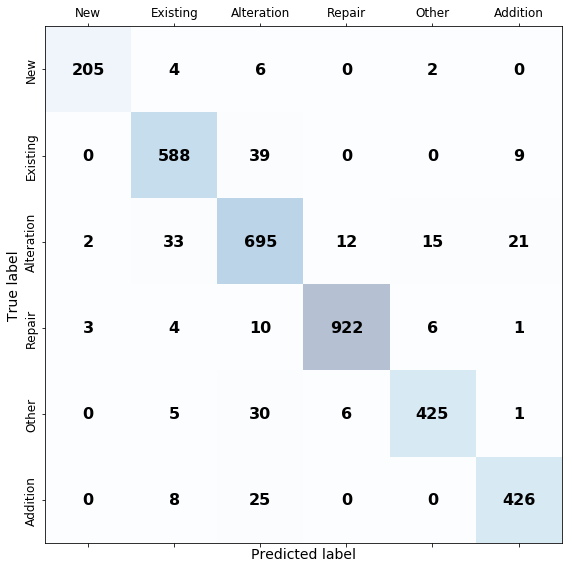

In [40]:
# plot the confusion matrix
confmat_y = confusion_matrix(y_true=y_te.argmax(axis=1), y_pred=y_pred_classes)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(confmat_y, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_y.shape[0]):
    for j in range(confmat_y.shape[1]):
        ax.text(x=j, y=i, s=confmat_y[i, j], va='center', ha='center', fontdict={'fontsize': 16,'fontweight': 'bold'})

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1, 2, 3, 4, 5], ['New', 'Existing', 'Alteration', 'Repair', 'Other', 'Addition'])
plt.yticks([0, 1, 2, 3, 4, 5], ['New', 'Existing', 'Alteration', 'Repair', 'Other', 'Addition'], 
           rotation='vertical', va='center')
ax.grid(False)
plt.tight_layout()
plt.show()

### Plot the ROC curves

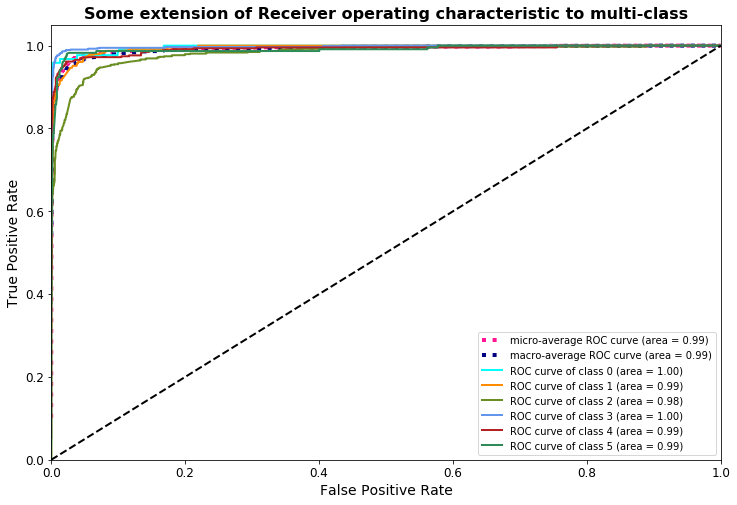

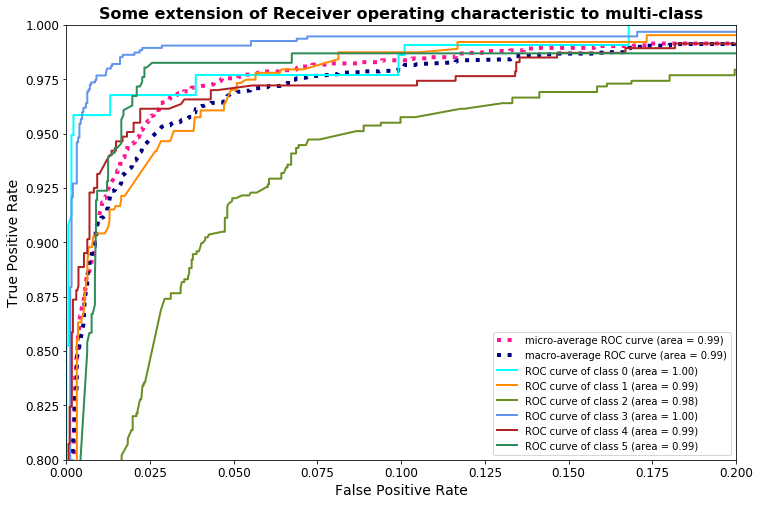

In [42]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_te.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'olivedrab', 'cornflowerblue', 'firebrick', 'seagreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'olivedrab', 'cornflowerblue', 'firebrick', 'seagreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### Use the model on a validate set (new data) 

In [53]:
import urllib
from sodapy import Socrata
from sklearn.preprocessing import label_binarize
#grab the data from the city's open data portal
client = Socrata("data.montgomeryal.gov", None)
results = client.get(dataset_identifier="7uyp-bn27", limit=99999, select=["Description, JobType, IssuedDate"], where="IssuedDate between '2018-05-01T12:00:00' and '2018-06-15T12:00:00'")
raw_data = pd.DataFrame.from_records(results)
#create copy of raw_data as df_new
df_new = raw_data.sort_index()
X_new = df_new['Description']
y_new = df_new['JobType']
y_new = lb.fit_transform(y_new)
n_y_new_bin_classes = y_new_bin.shape[1]
print(n_y_new_bin_classes)

6


In [50]:
# Transform new description data to tf-idf representation
X_new_bow = bow_transform.transform(X_new)
X_new_tfidf = tfidf_trfm.transform(X_new_bow)
X_new_tfidf.shape

(1052, 90128)

In [60]:
score, acc = jobtype_model.evaluate(X_new_tfidf, y_new, batch_size=32)

1052/1052 [==============================] - 2s 2ms/step


In [61]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.44319635793963313
Test accuracy: 0.9144486753206289


In [62]:
# Employ the model to make predictions on new data
y_new_pred = jobtype_model.predict(X_new_tfidf, batch_size=32)

In [63]:
y_new_pred

array([[6.9741520e-07, 1.8989893e-04, 9.9812359e-01, 4.4314752e-06,
        9.3521601e-05, 2.7892325e-05],
       [3.8033529e-06, 3.4881820e-04, 9.9748069e-01, 1.7630529e-05,
        1.7701836e-04, 4.0414885e-05],
       [1.9724835e-06, 2.9631937e-04, 9.2060006e-01, 7.0965041e-05,
        1.6475189e-02, 2.3998367e-05],
       ...,
       [3.7783607e-07, 6.7197178e-08, 3.3000393e-07, 9.9999583e-01,
        6.3668836e-08, 7.3344963e-10],
       [1.1063690e-03, 1.0712066e-02, 2.4756422e-02, 2.6708885e-04,
        3.2641059e-03, 9.6581495e-01],
       [4.7853911e-07, 1.9219863e-06, 4.1975882e-02, 3.4070017e-05,
        6.0368270e-01, 1.9398877e-07]], dtype=float32)

In [69]:
y_new_pred_classes = jobtype_model.predict_classes(X_new_tfidf, batch_size=32)
y_new_pred_classes

array([2, 2, 2, ..., 3, 5, 4], dtype=int64)

In [70]:
y_new.shape, y_new_pred_classes.shape

((1052, 6), (1052,))

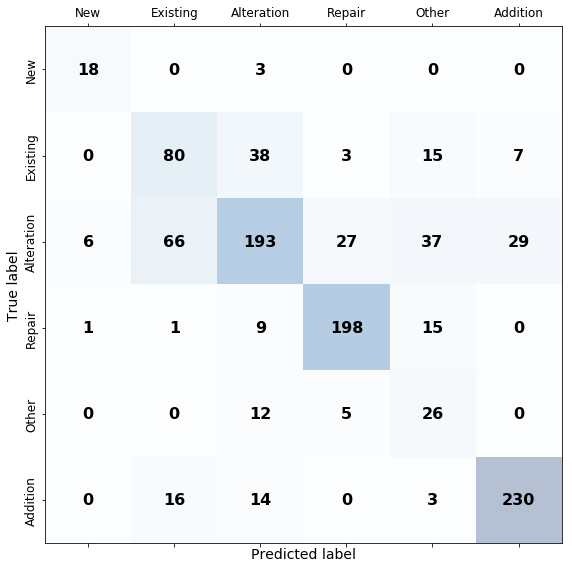

In [72]:
# plot the confusion matrix
confmat_y = confusion_matrix(y_new.argmax(axis=1), y_new_pred_classes)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(confmat_y, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_y.shape[0]):
    for j in range(confmat_y.shape[1]):
        ax.text(x=j, y=i, s=confmat_y[i, j], va='center', ha='center', fontdict={'fontsize': 16,'fontweight': 'bold'})

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1, 2, 3, 4, 5], ['New', 'Existing', 'Alteration', 'Repair', 'Other', 'Addition'])
plt.yticks([0, 1, 2, 3, 4, 5], ['New', 'Existing', 'Alteration', 'Repair', 'Other', 'Addition'], 
           rotation='vertical', va='center')
ax.grid(False)
plt.tight_layout()
plt.show()